# Motor Vehicle Registrations by State

![Cloudy outdoor scene with a parking lot full of cars, most of them white](cars.jpg)

Data set: <https://catalog.data.gov/dataset/motor-vehicle-registrations-dashboard-data>

In [1]:
import arviz as az
import math
import matplotlib.pyplot as plt
import pandas as pd
import preliz as pz
import pymc as pm
import seaborn as sns

In [2]:
df = pd.read_csv("motor-vehicle-registrations.csv"); df

,year,state,Auto,Bus,Truck,Motorcycle
0,1900,Alabama,40.0,0.0,0.0,0.0
1,1900,Alaska,0.0,0.0,0.0,0.0
2,1900,Arizona,20.0,0.0,0.0,0.0
3,1900,Arkansas,20.0,0.0,0.0,0.0
4,1900,California,780.0,0.0,0.0,0.0
...,...,...,...,...,...,...
6288,2020,Virginia,3057254.0,35463.0,4329294.0,184441.0
6289,2020,Washington (2),2800370.0,24172.0,4211411.0,221448.0
6290,2020,West Virginia (2),508663.0,3155.0,1102015.0,43529.0
6291,2020,Wisconsin (2),1901497.0,14941.0,3423523.0,276310.0


In [3]:
df = df[df["state"].isin(["California", "Texas", "Florida", "New York", "Pennsylvania", "Illinois"])]

In [4]:
def calculate_total(row):
    return row["Auto"] + row["Bus"] + row["Truck"] + row["Motorcycle"]

df = df.assign(total=df.apply(calculate_total, axis=1))
df = df.astype({"state": "category"})
df

,year,state,Auto,Bus,Truck,Motorcycle,total
4,1900,California,780.0,0.0,0.0,0.0,780.0
9,1900,Florida,10.0,0.0,0.0,0.0,10.0
13,1900,Illinois,600.0,0.0,0.0,0.0,600.0
32,1900,New York,500.0,0.0,0.0,0.0,500.0
38,1900,Pennsylvania,1480.0,0.0,0.0,0.0,1480.0
...,...,...,...,...,...,...,...
6246,2020,California,14201400.0,100828.0,15310597.0,785424.0,30398249.0
6251,2020,Florida,7841553.0,60173.0,9942703.0,620077.0,18464506.0
6274,2020,New York,4232748.0,81682.0,6625705.0,384620.0,11324755.0
6280,2020,Pennsylvania,4043715.0,55267.0,6230712.0,360493.0,10690187.0


<Axes: xlabel='total', ylabel='state'>

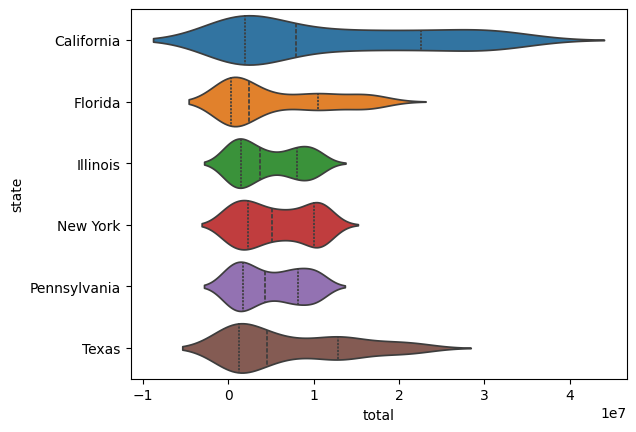

In [5]:
sns.violinplot(df, x="total", y="state", inner="quart", hue="state")

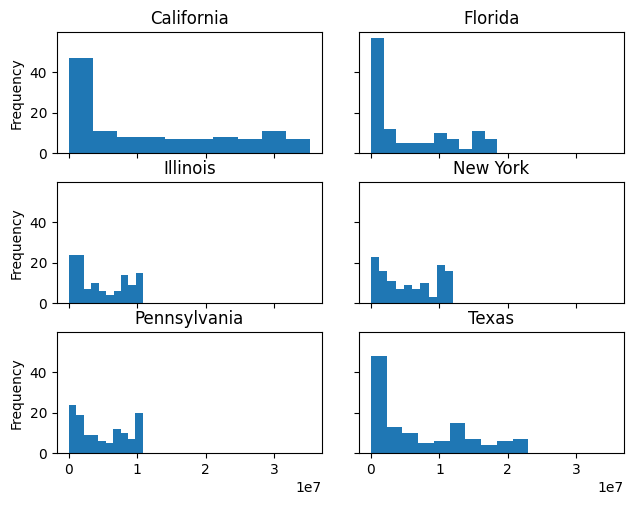

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
fig.tight_layout()
for i, state in enumerate(df.state.cat.categories):
    ax = axes[math.floor(0.5 * i)][i % 2]
    ax.set_title(state)
    df[df["state"] == state]["total"].plot.hist(ax=ax)

<https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population>

In [16]:
state_idx = df.state.cat.codes.values
state_codes = df.state.cat.categories
coords = {"state": state_codes}

In [8]:
pz.SkewStudentT().plot_interactive()

interactive(children=(FloatSlider(value=0.0, description='mu (-inf, inf)', max=10.0, min=-10.0, style=SliderSt…

In [9]:
pz.Gamma().plot_interactive(xy_lim="auto")

interactive(children=(FloatSlider(value=2.0, description='alpha (0, inf)', max=12.0, min=2.220446049250313e-16…

In [10]:
pz.StudentT().plot_interactive()

interactive(children=(FloatSlider(value=7.0, description='nu (0, inf)', max=17.0, min=2.220446049250313e-16, s…

In [11]:
pz.HalfStudentT().plot_interactive()

interactive(children=(FloatSlider(value=7.0, description='nu (0, inf)', max=17.0, min=2.220446049250313e-16, s…

In [13]:
with pm.Model(coords=coords) as model_hierarchical1:
    # Hyperpriors
    #mu_mu = pm.StudentT("μ→μ", mu=0, sigma=1, nu=1)
    #mu_sigma = pm.HalfStudentT("μ→σ", sigma=1, nu=1)
    #mu_nu = pm.HalfStudentT("μ→ν", sigma=1, nu=1)
    sigma_sigma = pm.HalfStudentT("σ→σ", sigma=1, nu=1)
    sigma_nu = pm.HalfStudentT("σ→ν", sigma=1, nu=1)
    
    # Prior
    #mu = pm.StudentT("μ", mu=mu_mu, sigma=mu_sigma, nu=mu_nu, dims="state")
    sigma = pm.HalfStudentT("σ", sigma=sigma_sigma, nu=sigma_nu, dims="state")
    mu = pm.StudentT("μ", mu=0, sigma=1, nu=1, dims="state") #mu=2000000
    a = pm.Gamma("a", alpha=8, beta=1, dims="state")
    b = pm.Gamma("b", alpha=2, beta=1, dims="state")
    
    # Likelihood
    y = pm.SkewStudentT("y",
                        mu=mu[state_idx],
                        sigma=sigma[state_idx],
                        a=a[state_idx],
                        b=b[state_idx],
                        observed=df["total"])
    
    data_hierarchical1 = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ→σ, σ→ν, σ, μ, a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1415 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/home/maxim/school/lasa/2024-2025/data-science/data-science-fundamentals/venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'σ→ν'}>, <Axes: title={'center': 'σ→ν'}>],
       [<Axes: title={'center': 'σ→σ'}>, <Axes: title={'center': 'σ→σ'}>]],
      dtype=object)

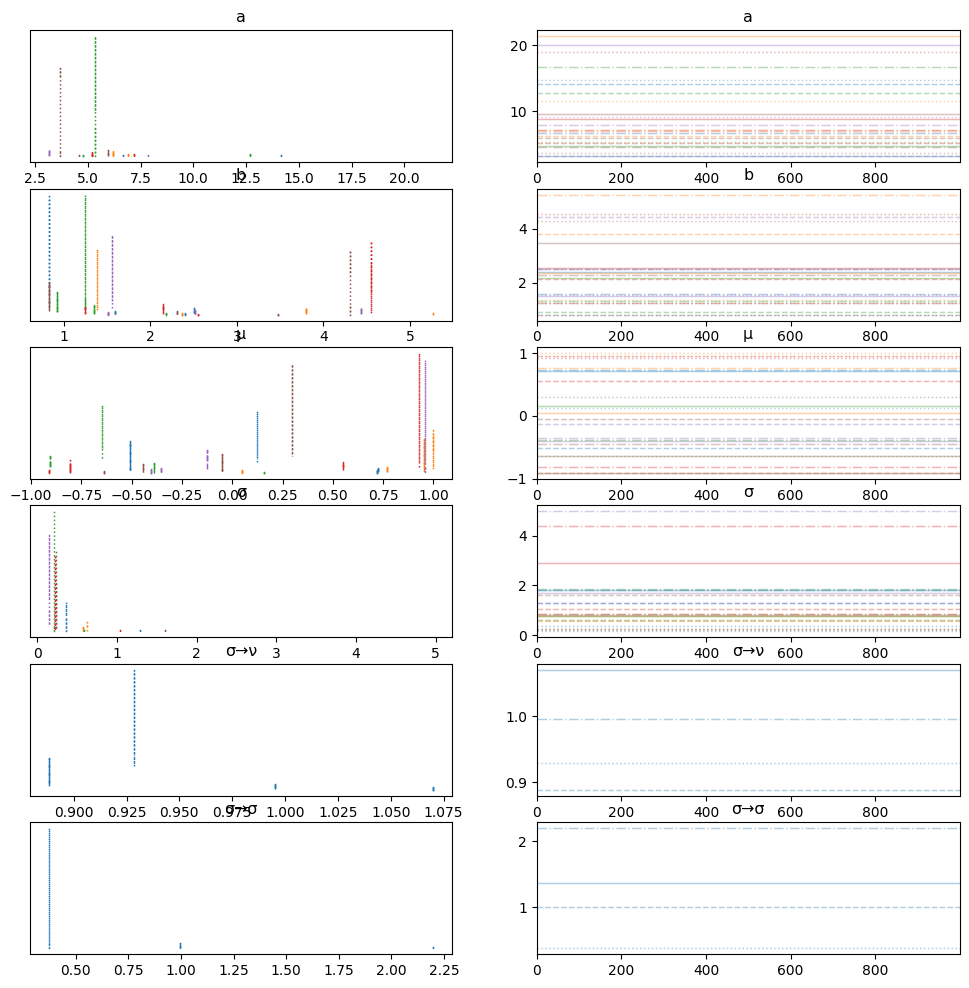

In [14]:
az.plot_trace(data_hierarchical1)

In [ ]:
az.rhat(data_hierarchical1)